In [217]:
import os
from os import listdir
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
import sys
sys.path.append("../../src")
from scipy.fft import fft
from FeaturesExtractorFromTSD import create_feature_dict_from_tsd
import matplotlib.pyplot as plt
import statistics

In [218]:
path_tds_angles = '../../results/big_dataset/TSD_angles'
folders = [x[0] for x in os.walk(path_tds_angles)]
folders.remove(path_tds_angles)

In [219]:
paths_to_csv = {}

In [220]:
for folder in folders:
    video_name = folder.split('\\')[-1]
    curr_paths_to_csv = [(f[:-4], os.path.join(folder, f)) for f in listdir(folder)]
    paths_to_csv[video_name] = curr_paths_to_csv

In [225]:
names_of_videos = [v for v in paths_to_csv.keys() ]
names_of_videos.sort(key=lambda v: v[::-1])

In [226]:
names_of_videos

['S001C',
 'S002C',
 'S007C',
 'S008C',
 'S009C',
 'S002I',
 'S003I',
 'S005I',
 'S007I',
 'S009I',
 'S001S',
 'S002S',
 'S004S',
 'S007S',
 'S009S']

In [227]:
len(names_of_videos)

15

In [228]:
def smooth_time_series(time_series, window_size):
    smoothed_series = []
    for i in range(len(time_series)):
        lower_bound = max(0, i - window_size)
        upper_bound = min(len(time_series), i + window_size + 1)
        window = time_series[lower_bound:upper_bound]
        average = sum(window) / len(window)
        smoothed_series.append(average)
    return smoothed_series

In [230]:
def calculate_sign_change_rate(time_series):
    count = 0
    for i in range(1, len(time_series)):
        if time_series[i] * time_series[i-1] < 0:
            count += 1
    #sign_change_rate = count / (len(time_series) - 1)
    return count

def calc_area(values):
  values = np.array(values)
  indices = np.where(values > 0)[0]
  area_pos = np.trapz(values[indices])
  indices = np.where(values < 0)[0]
  area_neg = np.trapz(values[indices])
  return area_pos, area_neg

def shift_data(series):
  median = statistics.median(series)
  shifted_data = [x - median for x in series]
  return shifted_data


In [231]:
experiment_suff = 'classif_wrong_pred'

In [363]:

def classify_time_series(angl_bow_mov, titles):
    num_rows = 8
    num_cols = 2
    shifted_smooth_series = []
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(50, 18))
    plt.rcParams['font.size'] = 20
    axes = axes.flatten()
    sign_change_arr = []
    #print(len(angl_bow_mov))
    for i, series in enumerate(angl_bow_mov):
      smoothed_data = smooth_time_series(series, 15)
      #neg_smoothed_data = negate_below_median(smoothed_data)
      title = titles[i]
      #num_sign_change = calculate_sign_change_rate(neg_smoothed_data)
      #print(title, " ", num_sign_change)

      ax = axes[i]
        #series = eliminate_lowest_values(series,10)
        #average = sum(time_series) / len(time_series)
      median = statistics.median(smoothed_data)
      #mode = statistics.mode(smoothed_data)
      shifted_data = shift_data(smoothed_data)
      #shifted_data = smooth_time_series(shifted_data, 15)
      ax.axhline(median, color='r', linestyle='--', label='median')
      ax.axhline(0, color='g', linestyle='--', label='median')
      #smoothed_data = smooth_time_series(series, 10) #np.convolve(series, np.ones(window_size) / window_size, mode='valid')
      ax.plot(shifted_data, label='Shifted Data')
      ax.plot(smoothed_data, label='Smoothed Data')
      #ax.set_title(title)
      #ax.legend()
      #smooth_series.append(smoothed_data)
      s =calculate_sign_change_rate(shifted_data)
      a1, a2 = calc_area(shifted_data)
      #print(title, s, a1,a2, a1+a2)
      sign_change_arr.append(s)
      shifted_smooth_series.append(shifted_data)

    arr = []

    count_false = 0
    count_true = 0

    mean_len = 0
    for v in shifted_smooth_series:
        s = calculate_sign_change_rate(v)
        arr.append(s)
        mean_len+=len(v)

    thres = int(statistics.mean(arr))
    mean_len /= len(shifted_smooth_series)
    thres_norm = int(1000*thres/mean_len)

    for i, series in enumerate(shifted_smooth_series):
        s = arr[i]
        title = titles[i]
        ax = axes[i]
        s_norm = int(1000*s/len(shifted_smooth_series[i]))

        print(f"s:{s}, thres:{thres}")
        if s_norm > thres_norm:
          title += f" Shuffled - {str('S'==title[-1])}"
        else:
          a1, a2 = calc_area(series)
          if abs(a2) < a1/2:
            title += f" Inverted - {str('I'==title[-1])}"
          else:
            title += f" Correct - {str('C'==title[-1])}"

        print(title)
        print('------------------')
        if 'False' in title:
            count_false+=1
        else:
            count_true+=1
        ax.set_title(title)

    plt.tight_layout()
    plt.savefig(experiment_suff+"ts_classification.png")
    plt.close()
    print(f"------------------- \n true predictions: {count_true} \n false predictions: {count_false} \n")
    #return shifted_smooth_series

In [364]:
bow_moving = []
titles = []

In [365]:
for i in range(len(names_of_videos)):
    curr_metric, curr_path = paths_to_csv[names_of_videos[i]][0]
    print(curr_path)
    print(curr_metric)
    title = curr_path.split('/')[-1].split('\\')[1]
    titles.append(title)
    print(title)
    angles = pd.read_csv(curr_path)['angle'].to_list()
    bow_moving.append(angles)

../../results/big_dataset/TSD_angles\S001C\angl_bow_mov.csv
angl_bow_mov
S001C
../../results/big_dataset/TSD_angles\S002C\angl_bow_mov.csv
angl_bow_mov
S002C
../../results/big_dataset/TSD_angles\S007C\angl_bow_mov.csv
angl_bow_mov
S007C
../../results/big_dataset/TSD_angles\S008C\angl_bow_mov.csv
angl_bow_mov
S008C
../../results/big_dataset/TSD_angles\S009C\angl_bow_mov.csv
angl_bow_mov
S009C
../../results/big_dataset/TSD_angles\S002I\angl_bow_mov.csv
angl_bow_mov
S002I
../../results/big_dataset/TSD_angles\S003I\angl_bow_mov.csv
angl_bow_mov
S003I
../../results/big_dataset/TSD_angles\S005I\angl_bow_mov.csv
angl_bow_mov
S005I
../../results/big_dataset/TSD_angles\S007I\angl_bow_mov.csv
angl_bow_mov
S007I
../../results/big_dataset/TSD_angles\S009I\angl_bow_mov.csv
angl_bow_mov
S009I
../../results/big_dataset/TSD_angles\S001S\angl_bow_mov.csv
angl_bow_mov
S001S
../../results/big_dataset/TSD_angles\S002S\angl_bow_mov.csv
angl_bow_mov
S002S
../../results/big_dataset/TSD_angles\S004S\angl_bow_

In [366]:
classify_time_series(bow_moving, titles)

s:117, thres:133
S001C Correct - True
------------------
s:97, thres:133
S002C Correct - True
------------------
s:101, thres:133
S007C Correct - True
------------------
s:80, thres:133
S008C Correct - True
------------------
s:82, thres:133
S009C Correct - True
------------------
s:121, thres:133
S002I Inverted - True
------------------
s:105, thres:133
S003I Inverted - True
------------------
s:146, thres:133
S005I Inverted - True
------------------
s:98, thres:133
S007I Inverted - True
------------------
s:112, thres:133
S009I Inverted - True
------------------
s:212, thres:133
S001S Shuffled - True
------------------
s:120, thres:133
S002S Shuffled - True
------------------
s:228, thres:133
S004S Shuffled - True
------------------
s:224, thres:133
S007S Shuffled - True
------------------
s:159, thres:133
S009S Shuffled - True
------------------
------------------- 
 true predictions: 15 
 false predictions: 0 



## prepare data

In [361]:
bow_moving_prepared = bow_moving.copy()

In [336]:
len(bow_moving[11])

7306

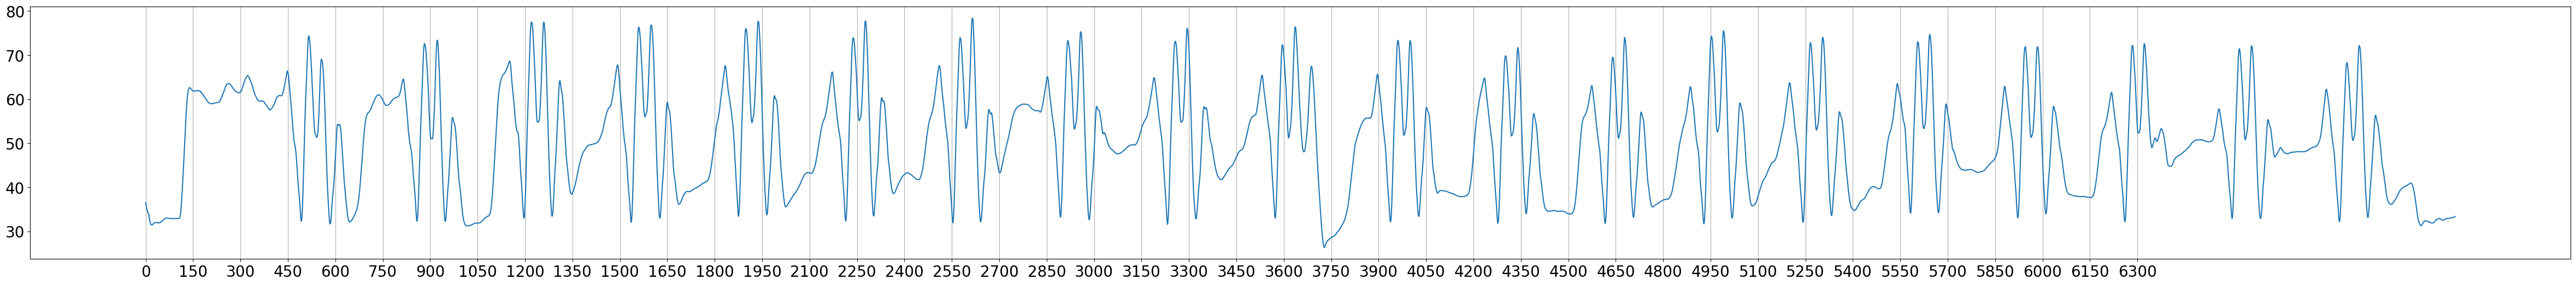

In [337]:
fig, ax = plt.subplots(figsize=(60, 6))
start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(0, 6400, 150))
ax.xaxis.grid(True)
ax.plot(smooth_time_series(bow_moving[11], 10));

In [338]:
print(titles[7])
bow_moving_prepared[7] = bow_moving_prepared[7][8000:]
print(titles[11])
# girl makes a lof of breaks, that are similar to the pattern of correct playing
bow_moving_prepared[11] = bow_moving[11][450:600] + \
                          bow_moving[11][900:1000]

S005I
S002S


In [339]:
for i in range(1100, 7400, 200):
    bow_moving_prepared[11] += bow_moving[11][i:i+100]

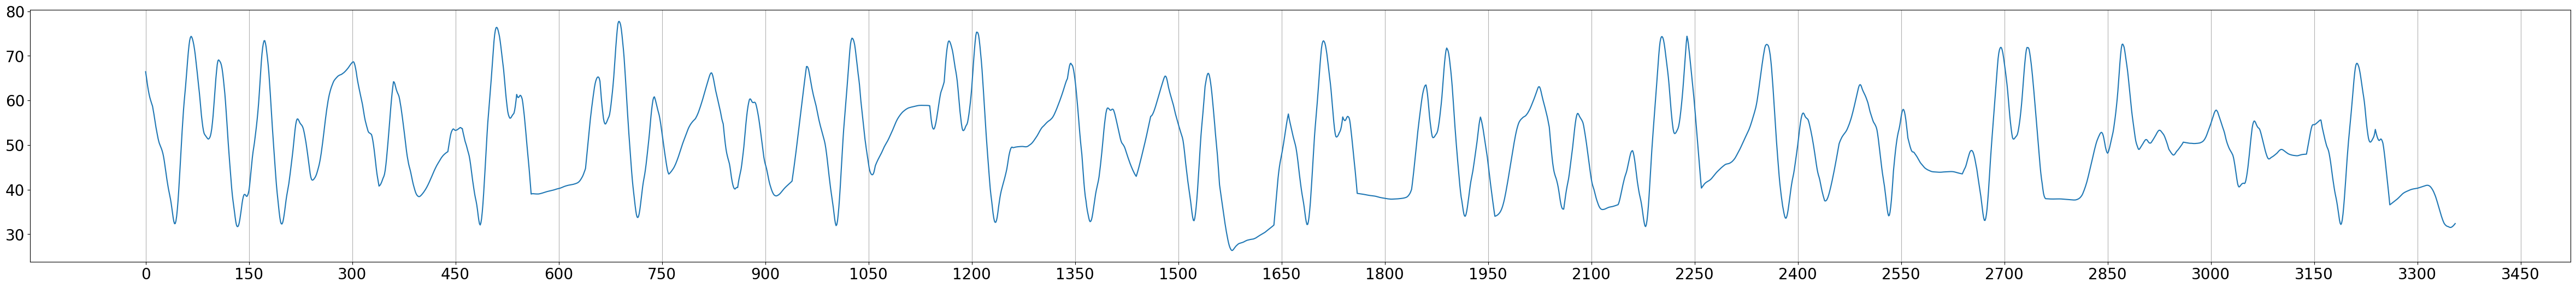

In [340]:
fig, ax = plt.subplots(figsize=(60, 6))
start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(0, 6400, 150))
ax.xaxis.grid(True)
ax.plot(smooth_time_series(bow_moving_prepared[11], 10));

In [347]:
print(titles[5])
#bow_moving_prepared[5] = bow_moving[5][:8500]

S002I


In [360]:
classify_time_series(bow_moving_prepared, titles)

s:10, thres:11
S001C Correct - True
------------------
s:9, thres:11
S002C Correct - True
------------------
s:9, thres:11
S007C Correct - True
------------------
s:8, thres:11
S008C Correct - True
------------------
s:9, thres:11
S009C Correct - True
------------------
s:11, thres:11
S002I Inverted - True
------------------
s:9, thres:11
S003I Inverted - True
------------------
s:11, thres:11
S005I Inverted - True
------------------
s:9, thres:11
S007I Inverted - True
------------------
s:9, thres:11
S009I Inverted - True
------------------
s:12, thres:11
S001S Shuffled - True
------------------
s:21, thres:11
S002S Shuffled - True
------------------
s:19, thres:11
S004S Shuffled - True
------------------
s:15, thres:11
S007S Shuffled - True
------------------
s:14, thres:11
S009S Shuffled - True
------------------
------------------- 
 true predictions: 15 
 false predictions: 0 

